## MultiHead Self-Attention

#### It is a neural network mechanism that enables models to focus on multiple parts of an input sequence simultaneously, capturing richer and more diverse realtionships between sequence elements.

**Self-Attention** means the model relates different positions within the same sequences(Eg. words in a sentence relate to one another).

**Multi-Head** means the mechanisms runs multiple self-attention operations in parallel, each with its own learned set of weights.Each "Head" can learn to focus on diffferent types of relationships or patterns in the data.

##### How it Works??
- **1** Compute Projections for Query,Key,Value matrices. For multi-head the input is projected using separate, trainable matrices for each head.

- **2** Scaled Dot-Product Attention: Each head indenpendently computes self-attention.

- **3** The above step is repeated for all heads, each processing different "views" of the input sentence. Each head can hence attend to different semantic,positional or syntactic patterns in the same sequence.

- **4** Concatenate the outputs from all heads and a final Linear transformation combines them into a single output tensor.


#### Why we are using Multiple Head???

- Because Each head learns to capture distinct relationships.

- Increased flexibility lets the model "see" the sequence from different perspective.

- This increases the expressiveness of models on various languages and vision tasks.

#### Key Features

- **Parallelism** - All heads are computed in parallel.
- **Permutations** - This attention mechanism does not inherently encode order, The model only learns about word/token order if Positional Encodings are added.
- **Scalability** - It enables *transformers*  to scale well to long sequences.

![mhself_attn.png](./imgs/mhself_attn.png)

In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 


In [8]:
class MHSA(nn.Module):
    def __init__(self, D, head_dim = 64):
        super().__init__()
        
        self.D = D
        self.wq = nn.Linear(D, D)
        self.wk = nn.Linear(D, D)
        self.wv = nn.Linear(D, D)
        self.wo = nn.Linear(D, D)
        
        assert D % head_dim == 0
        self.num_heads = D // head_dim 
        self.head_dim = head_dim
        
    def forward(self, x):
        B, S, D = x.shape  #B{Batch_size}, S{Seq_len}, D{Dim}
        q, k, v = self.wq(x), self.wk(x), self.wv(x)
        
        #View/Reshape the Matrices as (B,N_HEADS,S,HEAD_DIM)
        q = q.view(B, self.num_heads, S, self.head_dim).transpose(1,2)
        k = k.view(B, self.num_heads, S, self.head_dim).transpose(1,2)
        v = v.view(B, self.num_heads, S, self.head_dim).transpose(1,2)
        
        #Compute attn scores using einsum to do Q@K^T within each head
        #'bnqd' is short-hand for dimensions of Query Vector[i.e batch,num_heads,query_seq_len,dim]
        #'bnkd' is short-hand for dimensions of Query Vector[i.e batch,num_heads,key_seq_len,dim]
        #'bnqk' is short-hand for dimensions of Query Vector[i.e batch,num_heads,query_seq_len,key_seq_len]
        attn_weights = torch.einsum('bnqd, bnkd->bnqk', q, k) 
        
        #Scale the attn_weights by sqrt(d_k)
        attn_weights = attn_weights / (self.head_dim ** 0.5)
        
        #Compute the attn_scores 
        attn_scores = F.softmax(attn_weights, dim=-1) #We use dim = -1 because we apply softmax over the columns, which is the last dim.
        
        output = torch.einsum('bnqk, bnvd->bnqd', attn_scores, v)
        
        #Reshape the output from [B,N_HEADS,SEQ,HEAD_DIM]------>[B,S,D]
        output = output.view(B,S,D)
        
        return self.wo(output), attn_scores
        
        

In [10]:
B = 2
S = 4
D = 128
HEAD_DIM = 32

x = torch.randn(B,S,D)
mhsa = MHSA(D = D, head_dim=HEAD_DIM)
output, _ = mhsa(x)

#Check the shape of the output
assert output.shape == (B,S,D), f"Expected Shape: [{(B,S,D)}] but got [{(output.shape)}]"
print("="*30,f"Output_Shape:{output.shape}","="*30 )
print("="*30, f"Input Shape:{x.shape}", "="*30)
#test the attention weights sum to 1
q, k, v = mhsa.wq(x), mhsa.wk(x), mhsa.wv(x)
q = q.view(B,mhsa.num_heads, S, HEAD_DIM)
k = k.view(B,mhsa.num_heads, S, HEAD_DIM)
scores = torch.einsum('bnqd,bnkd->bnqk', q, k) / (HEAD_DIM ** 0.5)
attn_weigths = F.softmax(scores, dim = -1)

assert torch.allclose(attn_weigths.sum(dim = -1), torch.ones_like(attn_weigths.sum(dim = -1)), atol = 1e-6)


============================== Output_Shape:torch.Size([2, 4, 128]) ==============================
============================== Input Shape:torch.Size([2, 4, 128]) ==============================


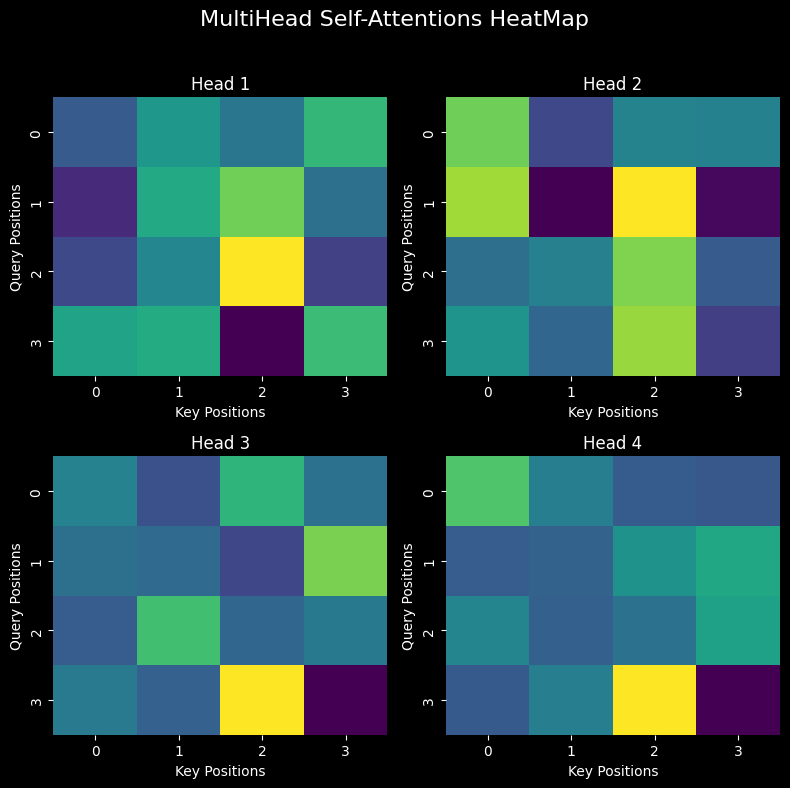

In [11]:
import matplotlib.pyplot as plt 
import seaborn as sns
import  math

dummy_input = torch.randn(B,S,D)
with torch.no_grad():
    output, attn_scores = mhsa(dummy_input)
    
attn_to_plot = attn_scores[0].cpu().numpy()
num_heads = mhsa.num_heads

cols = math.ceil(math.sqrt(num_heads))
rows = math.ceil(num_heads / cols)

plt.style.use('dark_background')
fig, axes = plt.subplots(rows, cols, figsize = (cols * 4, rows * 4))
axes = axes.flatten()

for i in range(num_heads):
    ax = axes[i]
    sns.heatmap(attn_to_plot[i], cmap='viridis', ax=ax, cbar=False)
    ax.set_title(f'Head {i + 1}')
    ax.set_xlabel("Key Positions")
    ax.set_ylabel("Query Positions")
    
    
for i in range(num_heads, len(axes)):
    fig.delaxes(axes[i])
    
fig.suptitle("MultiHead Self-Attentions HeatMap", fontsize = 16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()
    
